# DistilRoBERTa: Baseline vs Fine-tuned

This notebook:
1. Runs baseline DistilRoBERTa sentiment analysis
2. Fine-tunes DistilRoBERTa on our labeled data
3. Compares baseline vs fine-tuned performance

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import Dataset

In [6]:
# 1. Load Data
# Load cleaned data with VADER sentiment (for labels)
df_truth = pd.read_csv('data/truth_social_with_sentiment.csv')
df_truth['date'] = pd.to_datetime(df_truth['date'])

print(f"Total posts: {len(df_truth)}")
df_truth.head()

Total posts: 18778


,id,created_at,content,url,media,replies_count,reblogs_count,favourites_count,timestamp,date,cleaned_content,is_market_related,timestamp_est,hour_est,before_market_close,vader_sentiment,finbert_sentiment
0,115437112529618205,2025-10-25T22:15:50.076Z,"I am on my way to Malaysia, where I will sign ...",https://truthsocial.com/@realDonaldTrump/11543...,[],1134.0,3088.0,12468.0,2025-10-25 22:15:50.076000+00:00,2025-10-25,"I am on my way to Malaysia, where I will sign ...",False,2025-10-25 18:15:50.076000-04:00,18,False,0.9682,0.080414
1,115436984200406691,2025-10-25T21:43:11.929Z,"RT @realDonaldTrumpCanada was caught, red hand...",https://truthsocial.com/@realDonaldTrump/11543...,[],0.0,0.0,1.0,2025-10-25 21:43:11.929000+00:00,2025-10-25,"RT @realDonaldTrumpCanada was caught, red hand...",True,2025-10-25 17:43:11.929000-04:00,17,False,-0.8329,-0.353714
2,115436697060819133,2025-10-25T20:30:10.525Z,"Canada was caught, red handed, putting up a fr...",https://truthsocial.com/@realDonaldTrump/11543...,[],401.0,831.0,2715.0,2025-10-25 20:30:10.525000+00:00,2025-10-25,"Canada was caught, red handed, putting up a fr...",True,2025-10-25 16:30:10.525000-04:00,16,False,-0.8329,-0.300146
3,115436558661444946,2025-10-25T19:54:58.713Z,We have a very strong PEACE in the Middle East...,https://truthsocial.com/@realDonaldTrump/11543...,[],470.0,1314.0,4887.0,2025-10-25 19:54:58.713000+00:00,2025-10-25,We have a very strong PEACE in the Middle East...,False,2025-10-25 15:54:58.713000-04:00,15,True,0.9074,0.027445
4,115436151669143136,2025-10-25T18:11:28.545Z,Congressman Jimmy Patronis is a MAGA Warrior w...,https://truthsocial.com/@realDonaldTrump/11543...,[],313.0,1260.0,5237.0,2025-10-25 18:11:28.545000+00:00,2025-10-25,Congressman Jimmy Patronis is a MAGA Warrior w...,True,2025-10-25 14:11:28.545000-04:00,14,True,0.9643,0.154830


In [7]:
# 2. Baseline DistilRoBERTa Sentiment Analysis
# Load baseline DistilRoBERTa model (pre-trained on sentiment)
baseline_model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

try:
    baseline_tokenizer = AutoTokenizer.from_pretrained(baseline_model_name)
    baseline_model = AutoModelForSequenceClassification.from_pretrained(baseline_model_name)
    baseline_model.eval()
    print(f"Loaded: {baseline_model_name}")
except Exception as e:
    print(f"Could not load {baseline_model_name}: {e}")
    print("Falling back to base DistilRoBERTa...")
    baseline_model_name = "distilroberta-base"
    baseline_tokenizer = AutoTokenizer.from_pretrained(baseline_model_name)
    baseline_model = AutoModelForSequenceClassification.from_pretrained(
        baseline_model_name,
        num_labels=3,
        ignore_mismatched_sizes=True
    )
    baseline_model.eval()
    print(f"Loaded base: {baseline_model_name}")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Loaded: mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis


In [8]:
# Run baseline inference
print("Running baseline DistilRoBERTa inference...")
baseline_scores = []
total_posts = len(df_truth)

for i in range(total_posts):
    text = df_truth['cleaned_content'].iloc[i]
    
    if pd.isna(text) or text == "":
        baseline_scores.append(0.0)
        continue
    
    inputs = baseline_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = baseline_model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Assuming negative=0, neutral=1, positive=2 (or similar)
    # Calculate score as positive - negative
    if predictions.shape[1] == 3:
        # Check the actual order - could be neg/neu/pos or pos/neu/neg
        score = predictions[0][2].item() - predictions[0][0].item()
    else:
        score = 0.0
    
    baseline_scores.append(score)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{total_posts} posts...")

df_truth['baseline_distilroberta'] = baseline_scores

print(f"\nBaseline score range: {df_truth['baseline_distilroberta'].min():.3f} to {df_truth['baseline_distilroberta'].max():.3f}")
print(f"Average baseline sentiment: {df_truth['baseline_distilroberta'].mean():.3f}")
df_truth[['cleaned_content', 'vader_sentiment', 'baseline_distilroberta']].head(10)

Running baseline DistilRoBERTa inference...
Processed 1000/18778 posts...
Processed 2000/18778 posts...
Processed 3000/18778 posts...
Processed 4000/18778 posts...
Processed 5000/18778 posts...
Processed 6000/18778 posts...
Processed 7000/18778 posts...
Processed 8000/18778 posts...
Processed 9000/18778 posts...
Processed 10000/18778 posts...
Processed 11000/18778 posts...
Processed 12000/18778 posts...
Processed 13000/18778 posts...
Processed 14000/18778 posts...
Processed 15000/18778 posts...
Processed 16000/18778 posts...
Processed 17000/18778 posts...
Processed 18000/18778 posts...

Baseline score range: -0.998 to 1.000
Average baseline sentiment: 0.039


,cleaned_content,vader_sentiment,baseline_distilroberta
0,"I am on my way to Malaysia, where I will sign ...",0.9682,-0.000163
1,"RT @realDonaldTrumpCanada was caught, red hand...",-0.8329,0.019997
2,"Canada was caught, red handed, putting up a fr...",-0.8329,0.589968
3,We have a very strong PEACE in the Middle East...,0.9074,0.998133
4,Congressman Jimmy Patronis is a MAGA Warrior w...,0.9643,0.802067
5,"Richard Hudson is a Great Man, and TREMENDOUS ...",0.9905,0.995309
6,Congressman David Rouzer is a terrific Represe...,0.9800,0.002844
7,Congressman Addison McDowell is an America Fir...,0.9907,0.486486
8,Congresswoman Nicole Malliotakis is a Tremendo...,0.9922,0.007861
9,Congressman Jack Bergman is a Tremendous Champ...,0.9826,0.153806


In [9]:
# 3. Prepare Data for Fine-tuning
# Create labels from VADER sentiment (same as logistic regression approach)
def sentiment_to_label(score):
    if score > 0.05:
        return 2  # positive
    elif score < -0.05:
        return 0  # negative
    else:
        return 1  # neutral

df_truth['label'] = df_truth['vader_sentiment'].apply(sentiment_to_label)

print("Label distribution:")
print(df_truth['label'].value_counts())

# Split data for fine-tuning
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_truth['cleaned_content'].fillna('').tolist(),
    df_truth['label'].tolist(),
    test_size=0.2,
    random_state=42
)

print(f"\nTraining samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Label distribution:
label
2    8526
0    5656
1    4596
Name: count, dtype: int64

Training samples: 15022
Validation samples: 3756


In [10]:
# Create PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 4. Fine-tune DistilRoBERTa

In [11]:
# Load fresh DistilRoBERTa for fine-tuning
finetune_model_name = "distilroberta-base"
finetune_tokenizer = AutoTokenizer.from_pretrained(finetune_model_name)
finetune_model = AutoModelForSequenceClassification.from_pretrained(
    finetune_model_name,
    num_labels=3  # negative, neutral, positive
)

print(f"Loaded {finetune_model_name} for fine-tuning")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded distilroberta-base for fine-tuning


In [12]:
# Create datasets
train_dataset = SentimentDataset(train_texts, train_labels, finetune_tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, finetune_tokenizer)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 15022
Validation dataset size: 3756


In [13]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Training arguments
training_args = TrainingArguments(
    output_dir='./distilroberta_finetuned',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Create Trainer
trainer = Trainer(
    model=finetune_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("Starting fine-tuning...")
trainer.train()

print("\nFine-tuning complete!")

Starting fine-tuning...


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408600,0.401294,0.847710
2,0.280600,0.281750,0.894835
3,0.160100,0.417344,0.902290


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Fine-tuning complete!


In [14]:
# Evaluate on validation set
eval_results = trainer.evaluate()
print(f"\nValidation Accuracy: {eval_results['eval_accuracy']:.3f}")

/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Accuracy: 0.895


## 5. Run Fine-tuned Model on All Posts

In [16]:
# Run fine-tuned model inference
print("Running fine-tuned DistilRoBERTa inference...")
# Move model to CPU to avoid MPS device issues during inference
finetune_model.to('cpu')
finetune_model.eval()
finetuned_scores = []
total_posts = len(df_truth)

for i in range(total_posts):
    text = df_truth['cleaned_content'].iloc[i]
    
    if pd.isna(text) or text == "":
        finetuned_scores.append(0.0)
        continue
    
    inputs = finetune_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = finetune_model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # negative=0, neutral=1, positive=2
    score = predictions[0][2].item() - predictions[0][0].item()
    finetuned_scores.append(score)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{total_posts} posts...")

df_truth['finetuned_distilroberta'] = finetuned_scores

print(f"\nFine-tuned score range: {df_truth['finetuned_distilroberta'].min():.3f} to {df_truth['finetuned_distilroberta'].max():.3f}")
print(f"Average fine-tuned sentiment: {df_truth['finetuned_distilroberta'].mean():.3f}")
df_truth[['cleaned_content', 'vader_sentiment', 'baseline_distilroberta', 'finetuned_distilroberta']].head(10)

Running fine-tuned DistilRoBERTa inference...
Processed 1000/18778 posts...
Processed 2000/18778 posts...
Processed 3000/18778 posts...
Processed 4000/18778 posts...
Processed 5000/18778 posts...
Processed 6000/18778 posts...
Processed 7000/18778 posts...
Processed 8000/18778 posts...
Processed 9000/18778 posts...
Processed 10000/18778 posts...
Processed 11000/18778 posts...
Processed 12000/18778 posts...
Processed 13000/18778 posts...
Processed 14000/18778 posts...
Processed 15000/18778 posts...
Processed 16000/18778 posts...
Processed 17000/18778 posts...
Processed 18000/18778 posts...

Fine-tuned score range: -0.987 to 0.997
Average fine-tuned sentiment: 0.145


,cleaned_content,vader_sentiment,baseline_distilroberta,finetuned_distilroberta
0,"I am on my way to Malaysia, where I will sign ...",0.9682,-0.000163,0.992269
1,"RT @realDonaldTrumpCanada was caught, red hand...",-0.8329,0.019997,-0.764071
2,"Canada was caught, red handed, putting up a fr...",-0.8329,0.589968,-0.728757
3,We have a very strong PEACE in the Middle East...,0.9074,0.998133,0.990629
4,Congressman Jimmy Patronis is a MAGA Warrior w...,0.9643,0.802067,0.988465
5,"Richard Hudson is a Great Man, and TREMENDOUS ...",0.9905,0.995309,0.989681
6,Congressman David Rouzer is a terrific Represe...,0.9800,0.002844,0.990836
7,Congressman Addison McDowell is an America Fir...,0.9907,0.486486,0.993756
8,Congresswoman Nicole Malliotakis is a Tremendo...,0.9922,0.007861,0.994162
9,Congressman Jack Bergman is a Tremendous Champ...,0.9826,0.153806,0.989900


## 6. Compare Baseline vs Fine-tuned

In [17]:
# Calculate daily averages
daily_baseline = df_truth.groupby('date')['baseline_distilroberta'].mean().reset_index(name='avg_baseline_distilroberta')
daily_finetuned = df_truth.groupby('date')['finetuned_distilroberta'].mean().reset_index(name='avg_finetuned_distilroberta')

# Load market data
combined_df = pd.read_csv('data/combined_data_with_lr.csv')
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Merge with combined data
combined_df = pd.merge(combined_df, daily_baseline, on='date', how='left')
combined_df = pd.merge(combined_df, daily_finetuned, on='date', how='left')
combined_df['avg_baseline_distilroberta'] = combined_df['avg_baseline_distilroberta'].fillna(0)
combined_df['avg_finetuned_distilroberta'] = combined_df['avg_finetuned_distilroberta'].fillna(0)

print(f"Combined dataset: {len(combined_df)} days")
combined_df[['date', 'avg_baseline_distilroberta', 'avg_finetuned_distilroberta', 'Returns']].head(10)

Combined dataset: 986 days


,date,avg_baseline_distilroberta,avg_finetuned_distilroberta,Returns
0,2022-01-03,0.0,0.0,NaN
1,2022-01-04,0.0,0.0,-1.297057
2,2022-01-05,0.0,0.0,-3.072096
3,2022-01-06,0.0,0.0,-0.070282
4,2022-01-07,0.0,0.0,-1.083266
5,2022-01-10,0.0,0.0,0.065819
6,2022-01-11,0.0,0.0,1.502196
7,2022-01-12,0.0,0.0,0.396567
8,2022-01-13,0.0,0.0,-2.501633
9,2022-01-14,0.0,0.0,0.622258


In [18]:
# Compare correlations with market returns
baseline_corr = combined_df['avg_baseline_distilroberta'].corr(combined_df['Returns'])
finetuned_corr = combined_df['avg_finetuned_distilroberta'].corr(combined_df['Returns'])

print("Correlation with QQQ Returns:")
print(f"Baseline DistilRoBERTa: {baseline_corr:.4f}")
print(f"Fine-tuned DistilRoBERTa: {finetuned_corr:.4f}")
print(f"\nImprovement: {finetuned_corr - baseline_corr:.4f}")

# Compare with other models
print("\nComparison with other models:")
print(f"VADER: {combined_df['avg_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"FinBERT: {combined_df['avg_finbert_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"RoBERTa: {combined_df['avg_roberta_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"LR: {combined_df['avg_lr_sentiment'].corr(combined_df['Returns']):.4f}")

Correlation with QQQ Returns:
Baseline DistilRoBERTa: -0.0074
Fine-tuned DistilRoBERTa: 0.0403

Improvement: 0.0478

Comparison with other models:
VADER: 0.0327
FinBERT: -0.0160
RoBERTa: -0.0097
LR: 0.0029


In [19]:
# Compare how well fine-tuned model agrees with VADER (training labels)
baseline_vader_corr = combined_df['avg_baseline_distilroberta'].corr(combined_df['avg_sentiment'])
finetuned_vader_corr = combined_df['avg_finetuned_distilroberta'].corr(combined_df['avg_sentiment'])

print("Correlation with VADER (training labels):")
print(f"Baseline DistilRoBERTa: {baseline_vader_corr:.4f}")
print(f"Fine-tuned DistilRoBERTa: {finetuned_vader_corr:.4f}")
print(f"\nFine-tuning should increase agreement with VADER: {finetuned_vader_corr > baseline_vader_corr}")

Correlation with VADER (training labels):
Baseline DistilRoBERTa: 0.6058
Fine-tuned DistilRoBERTa: 0.9407

Fine-tuning should increase agreement with VADER: True


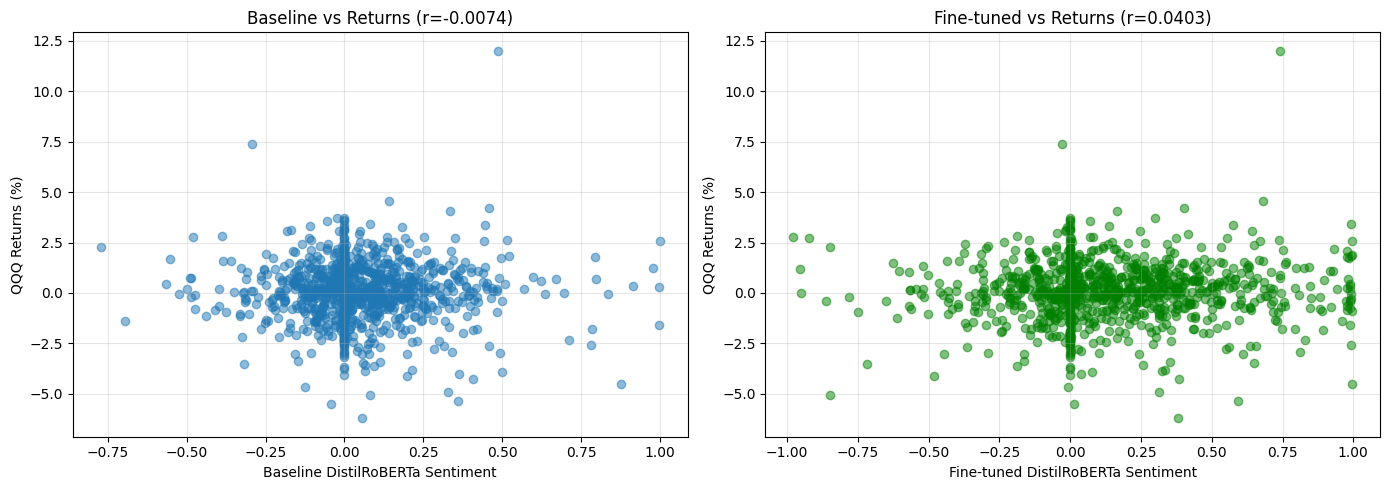

In [20]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline vs Returns
axes[0].scatter(combined_df['avg_baseline_distilroberta'], combined_df['Returns'], alpha=0.5)
axes[0].set_xlabel('Baseline DistilRoBERTa Sentiment')
axes[0].set_ylabel('QQQ Returns (%)')
axes[0].set_title(f'Baseline vs Returns (r={baseline_corr:.4f})')
axes[0].grid(True, alpha=0.3)

# Fine-tuned vs Returns
axes[1].scatter(combined_df['avg_finetuned_distilroberta'], combined_df['Returns'], alpha=0.5, color='green')
axes[1].set_xlabel('Fine-tuned DistilRoBERTa Sentiment')
axes[1].set_ylabel('QQQ Returns (%)')
axes[1].set_title(f'Fine-tuned vs Returns (r={finetuned_corr:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

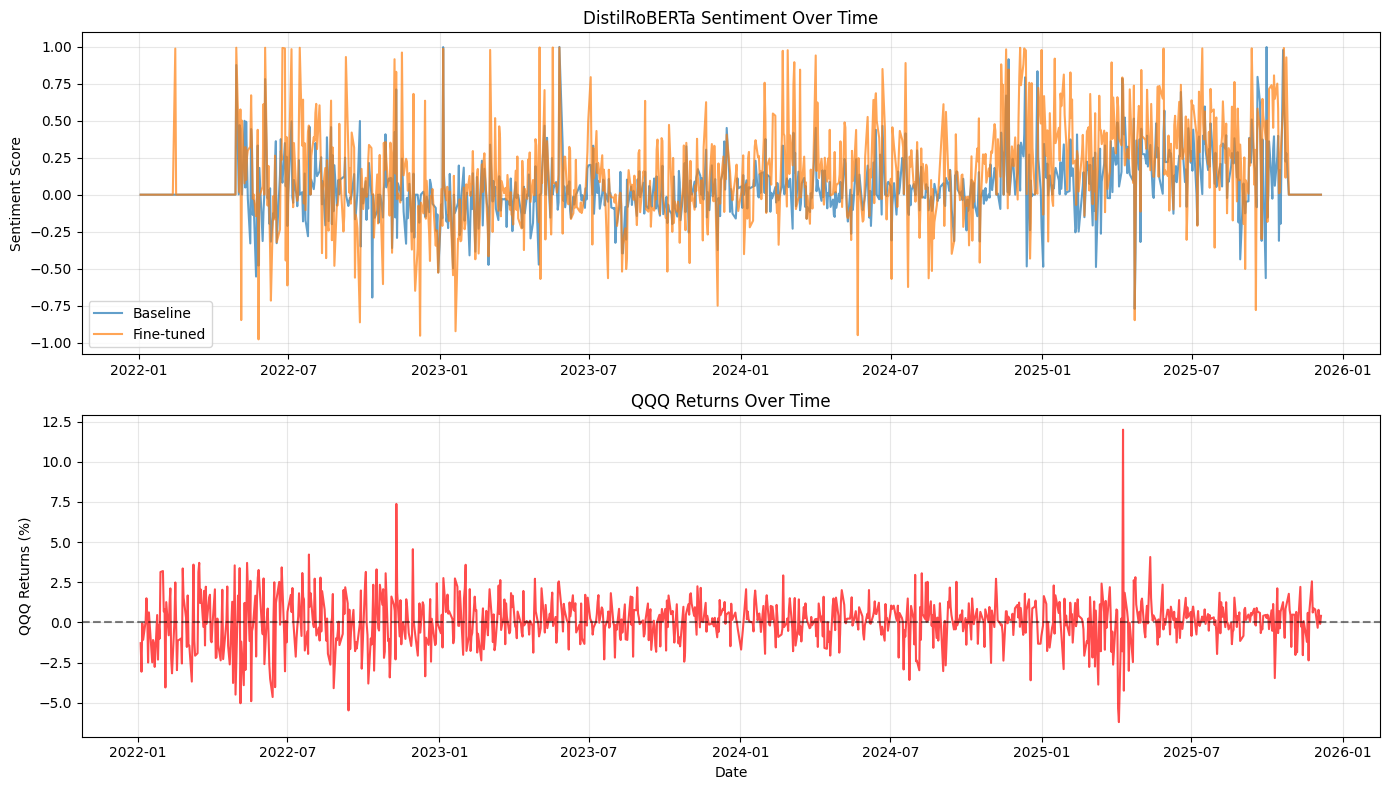

In [21]:
# Time series comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Sentiment over time
ax1.plot(combined_df['date'], combined_df['avg_baseline_distilroberta'], label='Baseline', alpha=0.7)
ax1.plot(combined_df['date'], combined_df['avg_finetuned_distilroberta'], label='Fine-tuned', alpha=0.7)
ax1.set_ylabel('Sentiment Score')
ax1.set_title('DistilRoBERTa Sentiment Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Returns over time
ax2.plot(combined_df['date'], combined_df['Returns'], color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel('QQQ Returns (%)')
ax2.set_title('QQQ Returns Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Results

In [22]:
# Save updated data
df_truth.to_csv('data/truth_social_with_distilroberta.csv', index=False)
combined_df.to_csv('data/combined_data_with_distilroberta.csv', index=False)

print("Results saved!")
print("- truth_social_with_distilroberta.csv")
print("- combined_data_with_distilroberta.csv")

Results saved!
- truth_social_with_distilroberta.csv
- combined_data_with_distilroberta.csv


In [24]:
# Summary statistics
print("SUMMARY: Baseline vs Fine-tuned DistilRoBERTa")
print(f"\nValidation Accuracy: {eval_results['eval_accuracy']:.3f}")
print(f"\nCorrelation with QQQ Returns:")
print(f"  Baseline:    {baseline_corr:.4f}")
print(f"  Fine-tuned:  {finetuned_corr:.4f}")
print(f"  Improvement: {finetuned_corr - baseline_corr:+.4f}")
print(f"\nCorrelation with VADER:")
print(f"  Baseline:    {baseline_vader_corr:.4f}")
print(f"  Fine-tuned:  {finetuned_vader_corr:.4f}")
print(f"  Improvement: {finetuned_vader_corr - baseline_vader_corr:+.4f}")

SUMMARY: Baseline vs Fine-tuned DistilRoBERTa

Validation Accuracy: 0.895

Correlation with QQQ Returns:
  Baseline:    -0.0074
  Fine-tuned:  0.0403
  Improvement: +0.0478

Correlation with VADER:
  Baseline:    0.6058
  Fine-tuned:  0.9407
  Improvement: +0.3349
